In [1]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import networkx as nx
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.cluster import OPTICS
from sklearn.cluster import OPTICS, DBSCAN
from fastnode2vec import Graph, Node2Vec
import faiss

/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Install a conda package in the current Jupyter kernel
#import sys
#!conda install --yes --prefix {sys.prefix} fastnode2vec
#!echo $PATH


In [42]:
# Create a NetworkX graph
n = 10000
tau1 = 3
tau2 = 1.5
mu = 0.2
min_community=25
seed=10
avg_deg = 5
G = nx.LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=avg_deg, min_community=min_community, seed=seed)
print(G)
#nx.write_graphml(G, "LFR_n_10000_tau1_3_tau2_1.5_mu_0.2_k_5_mincomm_25_seed_10.graphml")

# Create a Fastnode2vec Graph
fastnode2vec_graph = Graph(list(G.edges()), directed = False, weighted = False)

Graph with 10000 nodes and 20696 edges


In [43]:
#print(f"LFR_n_{n}_tau1_{tau1}_tau2_{tau2}_mu_{mu}_k_5_mincomm_{min_community}_seed_{seed}")

LFR_n_10000_tau1_3_tau2_1.5_mu_0.2_k_5_mincomm_25_seed_10


We need a coherent list of community labels, since community of node 1 gives a set of all elements node 1 belongs alongside in a community

In [37]:
comm_dict = nx.get_node_attributes(G,"community")
comm_dict = list(comm_dict.values())
# Sample list with sets

# Get unique sets
unique_sets = list(set(tuple(s) for s in comm_dict))
# Convert the unique sets back to a list of sets
unique_list_of_sets = [set(s) for s in unique_sets]

In [38]:
node_to_comm_mapping = {}

for node in list(G.nodes()):
    for set_index, current_set in enumerate(unique_list_of_sets):

        if node in current_set:
            node_to_comm_mapping[node] = set_index+1
membership = np.array(list(node_to_comm_mapping.values()))

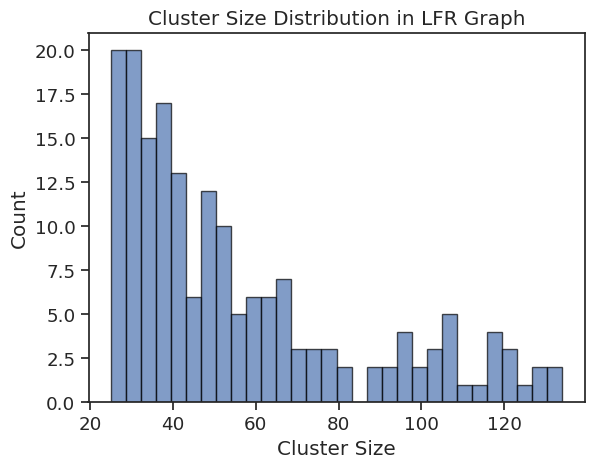

In [39]:
# Create a histogram of the element lengths
plt.hist([len(element) for element in unique_list_of_sets], bins=30, edgecolor='black', alpha=0.7)

# Set plot labels and title
plt.xlabel('Cluster Size')
plt.ylabel('Count')
plt.title('Cluster Size Distribution in LFR Graph')

# Show the histogram
plt.show()

In [44]:
n2v = Node2Vec(fastnode2vec_graph, dim=64, walk_length=100, window=10, p=2.0, q=0.5, workers=2)

n2v.train(epochs=100)

print(n2v.wv[0])
n2v.wv.save(f"LFR_n_{n}_tau1_{tau1}_tau2_{tau2}_mu_{mu}_k_5_mincomm_{min_community}_seed_{seed}.txt.gz.wv")

[ 0.08941493  0.4989015   0.24794751  0.1404284   0.3168029   0.25671262
 -0.37358585 -0.10563627 -0.08683343 -0.02492592  1.3233691  -0.36259004
  0.29713738 -0.18493032 -0.05496846  0.22772864 -0.46676853  1.0189213
 -0.20834513  0.26013038  0.19360377 -0.7415873   0.5819358   0.10166718
 -0.536768    0.5492056   0.732291   -0.2915781   0.59505045 -0.05540888
 -0.18504176  0.26671708  0.05029052  0.24074233  0.33896652 -0.8449944
 -0.8198735  -0.12450886 -0.30232462  0.17107996 -0.22191757  0.51197624
  0.8424802  -0.46666303  0.7769731  -1.0756842   0.2823347   0.04209713
 -0.08371928 -0.55413795 -0.42497292 -0.9659852   0.49747676 -0.24172181
  0.36311904 -0.5136287   0.70758563  0.4155904  -0.9526732  -0.4446999
  0.2217613  -0.90546113  0.564355    0.49776518]


In [45]:
# To Load Embeddings:
from gensim.models import KeyedVectors

#wv = KeyedVectors.load("LFR_n_10000_tau1_3_tau2_1.5_mu_0.2_k_5_mincomm_25_seed_10.txt.gz.wv", mmap='r')
wv = KeyedVectors.load((f"LFR_n_{n}_tau1_{tau1}_tau2_{tau2}_mu_{mu}_k_5_mincomm_{min_community}_seed_{seed}.txt.gz.wv"), mmap='r')



In [46]:
len(wv), len(wv[0]), len(unique_list_of_sets)

(10000, 64, 180)

## Reproducing results

In [47]:
# Need net, node_table and emb files
# net is G, emb files are wv, node_table probably
# has some info about ground truth community labels or smth like that.

# Define a function that calculates element-centric similarity:
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sparse.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected


In [48]:
wv_array = np.vstack([wv[node] for node in list(G.nodes())])

# Normalize the vector of each node to have unit length. This normalization improves clustering.
X = np.einsum("ij,i->ij", wv_array, 1 / np.maximum(np.linalg.norm(wv_array, axis=1), 1e-24))
X = wv_array.copy()
# Clustering
kmeans = KMeans(n_clusters= len(unique_list_of_sets), random_state=0).fit(X)
dbscan = DBSCAN().fit(X)
optics = OPTICS().fit(X)

test_labels = kmeans.labels_

# Evaluate the clustering
score_kmeans = calc_esim(membership, kmeans.labels_)
score_dbscan = calc_esim(membership, dbscan.labels_)
score_optics = calc_esim(membership, optics.labels_)

print(f"Element-centric similarity:") 
print(f"K-means: {score_kmeans}")
print(f"DBSCAN: {score_dbscan}") # Something Wrong
print(f"OPTICS: {score_optics}") # Something Wrong


/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Element-centric similarity:
K-means: 0.7154226068751373
DBSCAN: 0.0
OPTICS: 0.035391201605613015


/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

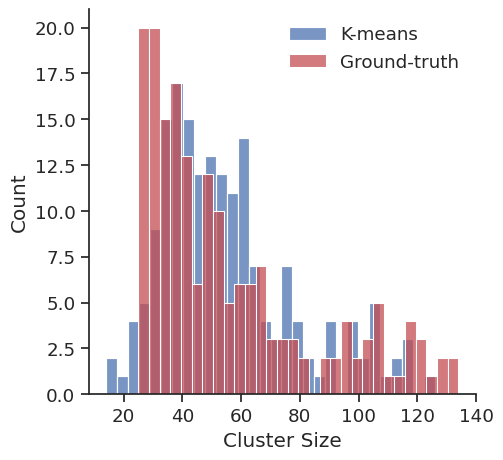

In [49]:
clus_sz = np.unique(membership, return_counts=True)[1] 
clus_sz_kmeans = np.unique(kmeans.labels_, return_counts=True)[1]
clus_sz_dbscan = np.unique(dbscan.labels_, return_counts=True)[1]
clus_sz_optics = np.unique(optics.labels_, return_counts=True)[1]
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(clus_sz_kmeans, bins = 30, color = sns.color_palette().as_hex()[0],label = "K-means", ax = ax)
#sns.histplot(clus_sz_dbscan, bins = 30, color = sns.color_palette().as_hex()[1],label = "DBSCAN", ax = ax)
#sns.histplot(clus_sz_optics, bins = 30, color = sns.color_palette().as_hex()[2],label = "OPTICS", ax = ax)
sns.histplot(clus_sz, bins = 30, color = sns.color_palette().as_hex()[3], label= "Ground-truth", ax = ax) 
ax.legend(frameon = False) 
ax.set_xlabel("Cluster Size")
sns.despine()

### The cluster size distribution is right skewed and fat tailed. (N/A for N=1000)
Many communities are small (<40) but large ones exist too. The K means does detect some communities of higher size. Maybe the order of magnitude is not sufficiently large, but still not perfectly of course.  
(#TODO: Increase order of magnitude by 1)

In [50]:
def find_knn_edges(emb, num_neighbors, 
                   target=None, metric="dotsim",
                   device=None):
    
    k = int(np.minimum(num_neighbors + 1, emb.shape[0]).astype(int))
    indices, distances = find_knn(emb if target is None else target, emb,
                                  num_neighbors=k,
                                  metric=metric,
                                  device=device)
    r = np.outer(np.arange(indices.shape[0]), np.ones((1, indices.shape[1]))).astype(int)
    r, c, distances = (r.reshape(-1),indices.astype(int).reshape(-1),distances.reshape(-1))
    if len(r) == 0:
        return r, c, distances 
    
    return r, c, distances


def find_knn(target, emb, num_neighbors, metric="dotsim", device=None): 
    if metric == "dotsim":
        index = faiss.IndexFlatIP(emb.shape[1]) 
    else:
        index = faiss.IndexFlatL2(emb.shape[1]) 
    
    if device is None:
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
        # This line takes too long to load.
    else: 
        try:
            gpu_id = int(device[-1])
            res = faiss.StandardGpuResources()
            index = faiss.index_cpu_to_gpu(res, gpu_id, index)
            index.add(emb.astype(np.float32))
            distances, indices = index.search(
                target.astype(np.float32), k=num_neighbors
            )
        except RuntimeError:
            if metric == "dotsim":
                index = faiss.IndexFlatIP(emb.shape[1]) 
            else:
                index = faiss.IndexFlatL2(emb.shape[1])
            
            index.add(emb.astype(np.float32))
            distances, indices = index.search(target.astype(np.float32),
                                              k=num_neighbors)
    return indices, distances

In [14]:
#If you want to find the GPU IDs. But I recommend gpustat on terminal to see live usage.
'''

import pynvml

def find_gpu_id():
    pynvml.nvmlInit()
    num_gpus = pynvml.nvmlDeviceGetCount()
    
    gpu_info = []
    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        name = pynvml.nvmlDeviceGetName(handle)
        gpu_info.append(f"GPU {i}: {name}")
    
    pynvml.nvmlShutdown()
    
    return gpu_info

if __name__ == "__main__":
    gpu_info = find_gpu_id()
    for info in gpu_info:
        print(info)
'''

GPU 0: NVIDIA GeForce RTX 2080 Ti
GPU 1: NVIDIA GeForce RTX 2080 Ti
GPU 2: NVIDIA GeForce RTX 2080 Ti
GPU 3: NVIDIA GeForce RTX 2080 Ti


In [51]:
rpos, cpos, vpos = find_knn_edges(wv_array, num_neighbors=100, device = "cuda:3")
cneg = np.random.choice(wv_array.shape[0], len(cpos))
vneg = np.array(np.sum(wv_array[rpos, :] * wv_array[cneg, :], axis=1)).reshape(-1)

In [23]:
#import os
#os.system('say "Beer time."')

In [52]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression()
model.fit(
    np.concatenate([vpos, vneg]).reshape((-1, 1)),
    np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
)
w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
print(f"w0={w1}, b1={b0}")

w0=2.0377174119863546, b1=14.770159167558669


In [53]:
import numba

def louvain(Z, w1, b0, num_neighbors=100, iteration = 50, device = "cuda:0", return_member_matrix=False):
    """"Louvain algorithm for vecto data
    :param Z: embedding
    :type Z: numpy.ndarray
    :param w1: regression coefficient
    :type w1: float
    :param b0: intercept
    :type b0: float
    :param num_neighbors: Number of neighbors, defaults to 100
    :type num_neighbors: int, optional
    :param iteration: The maximum number of iterations, defaults to 50
    :type iteration: int, optional
    :param device: _description_, defaults to "cuda:0"
    :type device: str, optional
    :param return_member_matrix: _description_, defaults to False
    :type return_member_matrix: bool, optional
    :return: _description_
    :rtype: _type_
    """
    # Initialize the intermediate variables
    num_nodes = Z.shape[0]
    node_size = np.ones(num_nodes)
    U = sparse.identity(num_nodes, format="csr")
    Vt = Z.copy()
    
    # The main loop for the Louvain algorithm
    while True:
        # Find the community assignment for the given graph # using a label switching algorithm
        cids_t = label_switching(
               Z=Vt,
               num_neighbors=num_neighbors,
               rho=b0/w1,
               node_size=node_size,
               epochs=iteration,
               device=device,
                )
        
        # This is to make the community labels continuous integer variables
        _, cids_t = np.unique(cids_t, return_inverse=True)
        
        # If no merging, we are good to go out from the loop
        if int(max(cids_t) + 1) == Vt.shape[0]: 
            break
            
        # If two nodes are merged, we created an aggregated network, 
        #where a node represents a community.
        
        num_nodes_t = len(cids_t)
        k = int(np.max(cids_t) + 1)
        Ut = sparse.csr_matrix((np.ones(num_nodes_t), (np.arange(num_nodes_t), cids_t)), shape=(num_nodes_t, k))
        U = U @ Ut
        Vt = Ut.T @ Vt
        
        node_size = np.array(Ut.T @ node_size).reshape(-1)
    if return_member_matrix: 
        return U
    cids = np.array((U @ sparse.diags(np.arange(U.shape[1]))).sum(axis=1)).reshape(-1)

    return cids

#
# Clustering based on a label switching algorithm
#
def label_switching(Z, rho, num_neighbors=50, node_size=None, device=None,epochs=50):
    num_nodes, dim = Z.shape
    if node_size is None:
        node_size = np.ones(num_nodes)
    Z = Z.copy(order="C").astype(np.float32)
    # Construct the candidate graph
    Z1 = np.hstack([Z, np.ones((num_nodes, 1))])
    Zrho = np.hstack([Z, -rho * node_size.reshape((-1, 1))])

    r, c, v = find_knn_edges(
        Zrho,
        target=Z1,
        num_neighbors=num_neighbors,
        metric="cosine",
        device=device)
    A = sparse.csr_matrix((v, (r, c)), shape=(num_nodes, num_nodes))
    
    return _label_switching_(
        A_indptr=A.indptr,
        A_indices=A.indices,
        Z=Z,
        num_nodes=num_nodes,
        rho=rho,
        node_size=node_size,
        epochs=epochs)

#@numba.jit(nopython=True, cache=True)
def _label_switching_(A_indptr, A_indices, Z, num_nodes, rho, node_size,epochs=100):
    Nc = np.zeros(num_nodes)
    cids = np.arange(num_nodes)
    Vc = Z.copy()
    Vnorm = np.sum(np.multiply(Z, Z), axis=1).reshape(-1) 
    for nid in range(num_nodes):
            Nc[nid] += node_size[nid]
    for _it in range(epochs):
        order = np.random.choice(num_nodes, size=num_nodes, replace=False) 
        updated_node_num = 0
        
        for _k, node_id in enumerate(order):
            # Get the weight and normalized weight
            neighbors = A_indices[A_indptr[node_id] : A_indptr[node_id + 1]]

            # Calculate the grain
            c = cids[node_id]
            clist = np.unique(cids[neighbors])
            next_cid = -1
            dqmax = 0
            qself = (
                np.sum(Z[node_id, :] * Vc[c, :])
                - Vnorm[node_id]
                - rho * node_size[node_id] * (Nc[c] - node_size[node_id]))

            for cprime in clist:
                if c == cprime: 
                    continue
                dq = (np.sum(Z[node_id, :] * Vc[cprime, :])
                        - rho * node_size[node_id] * Nc[cprime]) - qself
                if dqmax < dq:
                    next_cid = cprime
                    dqmax = dq
            if dqmax <= 1e-16: 
                continue

            Nc[c] -= node_size[node_id]
            Nc[next_cid] += node_size[node_id]

            Vc[c, :] -= Z[node_id, :]
            Vc[next_cid, :] += Z[node_id, :]

            cids[node_id] = next_cid
            updated_node_num += 1

        if (updated_node_num / np.maximum(1, num_nodes)) < 1e-3: 
            break
    return cids

In [54]:
gs = louvain(wv_array, w1, b0, device = "cuda:3")

In [55]:
score_proposed = calc_esim(membership, gs) 
print(f"Element-centric similarity:")
print(f"Proposed: {score_proposed}")

Element-centric similarity:
Proposed: 0.7348197182129529


This element-centric similarity is markedly different from the one gotten by Sadamori. The only difference in my implementation is the way in which the embedding vectors where gotten. I used Louis Abraham's Fastnode2vec to get the embedding vectors.